In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU
from tqdm import tqdm, notebook
import tensorflow as tf


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

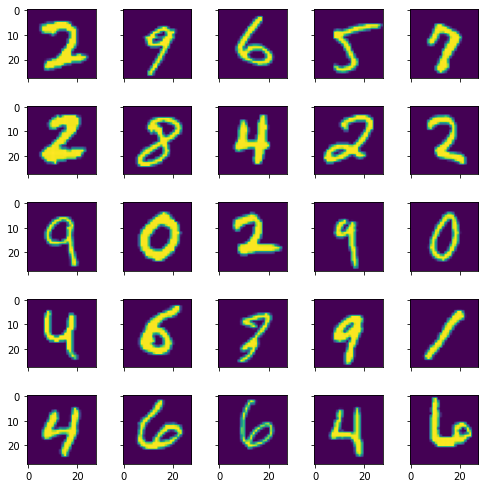

In [3]:
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(7,7))
plt.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[np.random.randint(0, len(x_train))])
plt.show()

## Filter only for zeros

to reduce training time

# Reshape the data

In [6]:
x_train = x_train / 255

In [7]:
x_train = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [8]:
x_train.min(), x_train.max()

(-1.0, 1.0)

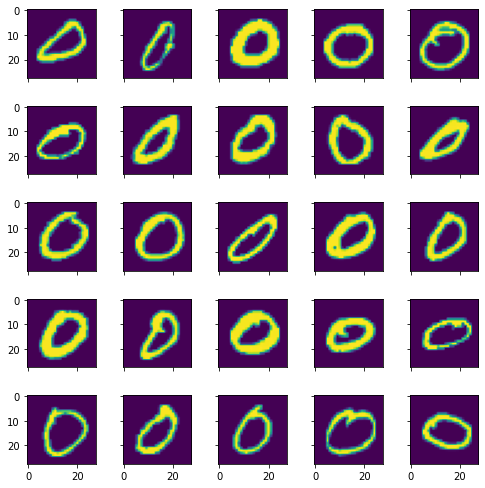

In [15]:
only_zeros = x_train[y_train==0]
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(7,7))
plt.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ax.imshow(only_zeros[np.random.randint(0, len(only_zeros))][:, :, 0])
plt.show()

# Creating the model

In [17]:
coding_size = 100



In [24]:
generator = Sequential()

generator.add(Dense(7 * 7 * 128, input_shape=[coding_size]))
generator.add(Reshape((7, 7, 128)))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64,
                              kernel_size=5,
                              strides=2,
                              padding='same',
                              activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1,
                              kernel_size=5,
                              strides=2,
                              padding='same',
                              activation='tanh'))

In [25]:
discriminator = Sequential()
discriminator.add(Conv2D(64,
                         kernel_size=5,
                         strides=2,
                         padding='same',
                         activation=LeakyReLU(0.3),
                         input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128,
                         kernel_size=5,
                         strides=2,
                         padding='same',
                         activation=LeakyReLU(0.3),
                         input_shape=[28, 28, 1]))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [26]:
GAN = Sequential([generator, discriminator])

In [27]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False # false here to compile the GAN

In [28]:
GAN.compile(loss='binary_crossentropy', optimizer='adam')

In [29]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [30]:
batch_size = 32
my_data = only_zeros

dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [31]:
generator, discriminator = GAN.layers

In [32]:
epochs=50
with tf.device('/device:gpu:0'):
    for epoch in notebook.tqdm(range(epochs), desc='Epoch', leave=True):
        i=0
        for x_batch in notebook.tqdm(dataset, desc='Batch:', leave=False):

            noise = tf.random.normal(shape=[batch_size, coding_size])
            gen_img = generator(noise)
            x_fake_vs_real = tf.concat([gen_img, tf.dtypes.cast(x_batch, tf.float32)],
                                       axis=0)
            y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_vs_real, y1)

            noise = tf.random.normal(shape=[batch_size, coding_size])
            y2 = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            GAN.train_on_batch(noise, y2)

In [33]:
noise = tf.random.normal(shape=[10, coding_size])

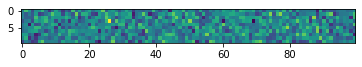

In [34]:
plt.imshow(noise)

In [35]:
images = generator(noise)

## Mode collapse avoided

Results differ this time 

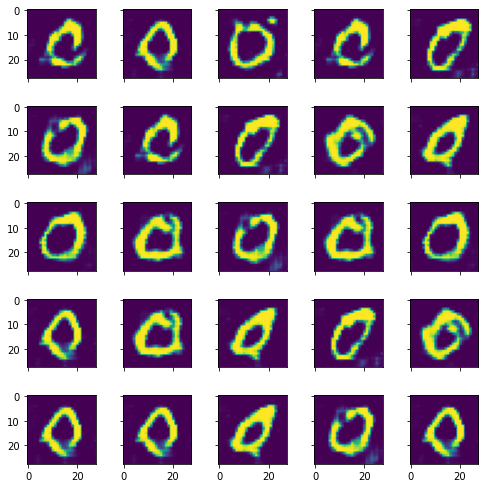

In [37]:
fig, axes = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(7,7))
plt.tight_layout()
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[np.random.randint(0, len(images))][:, :, 0])
plt.show()